# WH all hadronic analysis

Basic implementation of an all-hadronic WH search in the top-W scattering framework:
- Loose Lepton veto
- at least 2 AK8 jets
- high MET
- veto QCD with deltaPhi(AK8,MET) and deltaPhi(AK8) cuts
- use deepAK8 taggers

In [1]:
%load_ext autoreload
%autoreload 2

import os
import time
import glob
import re
import pandas as pd
from functools import reduce
from klepto.archives import dir_archive

import numpy as np
from tqdm.auto import tqdm
import coffea.processor as processor
from coffea.processor.accumulator import AccumulatorABC
from coffea.analysis_objects import JaggedCandidateArray
from coffea.btag_tools import BTagScaleFactor
from coffea import hist
import pandas as pd
import uproot_methods
import uproot
import awkward
import copy

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from Tools.config_helpers import *
from Tools.helpers import mergeArray, mt, get_scheduler_address

from Tools.objects import Collections
from Tools.cutflow import Cutflow

# This just tells matplotlib not to open any
# interactive windows.
matplotlib.use('Agg')

In [41]:
# Imports and defintions for the actual analysis to run

from Tools.WH_objects       import *
from Tools.WH_scalefactors  import LeptonSF
from Tools.WH_deepAK8       import getWTagSF
from Tools.WH_signalWeights import getSignalWeight
from Tools.WH_samples       import * 

year = 2017
signalPoint = 'TChiWH_800_1'


In [42]:

class analysisProcessor(processor.ProcessorABC):
    """Processor used for running the analysis"""
    def __init__(self):
        
        # we can use a large number of bins and rebin later
        dataset_axis        = hist.Cat("dataset",   "Primary dataset")
        pt_axis             = hist.Bin("pt",        r"$p_{T}$ (GeV)", 1000, 0, 1000)
        p_axis              = hist.Bin("p",         r"$p$ (GeV)", 1000, 0, 2500)
        ht_axis             = hist.Bin("ht",        r"$H_{T}$ (GeV)", 500, 0, 5000)
        mass_axis           = hist.Bin("mass",      r"M (GeV)", 1000, 0, 2000)
        eta_axis            = hist.Bin("eta",       r"$\eta$", 60, -5.5, 5.5)
        delta_axis          = hist.Bin("delta",     r"$\delta$", 100,0,10 )
        deltaPhi_axis          = hist.Bin("deltaPhi",     r"$\delta$", 64,0,3.2 )
        multiplicity_axis   = hist.Bin("multiplicity",         r"N", 20, -0.5, 19.5)
        norm_axis           = hist.Bin("norm",         r"N", 25, 0, 1)

        self._accumulator = processor.dict_accumulator({
            "MET_pt_baseline" :          hist.Hist("Counts", dataset_axis, pt_axis),
            "HT_baseline" :              hist.Hist("Counts", dataset_axis, ht_axis),
            "mtb_min_baseline" :         hist.Hist("Counts", dataset_axis, mass_axis),
            "MET_pt" :          hist.Hist("Counts", dataset_axis, pt_axis),
            "HT" :              hist.Hist("Counts", dataset_axis, ht_axis),
            "mtb_min" :         hist.Hist("Counts", dataset_axis, mass_axis),
            "MET_pt_SR" :       hist.Hist("Counts", dataset_axis, pt_axis),
            "MET_pt_CR" :       hist.Hist("Counts", dataset_axis, pt_axis),
            "MET_pt_VR_CR" :    hist.Hist("Counts", dataset_axis, pt_axis),
            "MET_pt_VR_SR" :    hist.Hist("Counts", dataset_axis, pt_axis),
            "MET_pt_TT" :       hist.Hist("Counts", dataset_axis, pt_axis),
            "HT_SR" :           hist.Hist("Counts", dataset_axis, ht_axis),
            "mtb_min_SR" :      hist.Hist("Counts", dataset_axis, mass_axis),
            "mth_min_SR" :      hist.Hist("Counts", dataset_axis, mass_axis),
            "mth_min" :         hist.Hist("Counts", dataset_axis, mass_axis),
            "mtw_min_SR" :      hist.Hist("Counts", dataset_axis, mass_axis),
            "lead_AK8_pt" :     hist.Hist("Counts", dataset_axis, pt_axis),
            "W_pt" :            hist.Hist("Counts", dataset_axis, pt_axis),
            "H_pt" :            hist.Hist("Counts", dataset_axis, pt_axis),
            "W_msoftdrop":      hist.Hist("Counts", dataset_axis, mass_axis),
            "H_msoftdrop":      hist.Hist("Counts", dataset_axis, mass_axis),
            "H_msoftdrop_incl": hist.Hist("Counts", dataset_axis, mass_axis),
            "W_mass":           hist.Hist("Counts", dataset_axis, mass_axis),
            "H_mass":           hist.Hist("Counts", dataset_axis, mass_axis),
            "W_eta" :           hist.Hist("Counts", dataset_axis, eta_axis),
            "H_eta" :           hist.Hist("Counts", dataset_axis, eta_axis),
            
            "N_b" :             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_AK4" :           hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_AK4_SR" :        hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_AK8" :           hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_H" :             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_W" :             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            
            "WH_deltaPhi":      hist.Hist("Counts", dataset_axis, delta_axis),
            "WH_deltaR":        hist.Hist("Counts", dataset_axis, delta_axis),
            "bb_deltaPhi":      hist.Hist("Counts", dataset_axis, delta_axis),
            "bb_deltaR":        hist.Hist("Counts", dataset_axis, delta_axis),
            "min_dphiJetMet4":  hist.Hist("Counts", dataset_axis, delta_axis),
            "min_dphiFatJetMet4":  hist.Hist("Counts", dataset_axis, delta_axis),
            "min_deltaRAK4AK8": hist.Hist("Counts", dataset_axis, delta_axis),
            "min_deltaRAK4AK8_SR": hist.Hist("Counts", dataset_axis, delta_axis),
            "dphiDiJet":        hist.Hist("Counts", dataset_axis, delta_axis),
            "dphiDiFatJet":     hist.Hist("Counts", dataset_axis, delta_axis),
            "antiQCDcorrelation": hist.Hist("Counts", dataset_axis, delta_axis, deltaPhi_axis),
            
            'TChiWH_1000_1':    processor.defaultdict_accumulator(int),
            signalPoint:        processor.defaultdict_accumulator(int),
            'WJets':            processor.defaultdict_accumulator(int),
            'QCD':              processor.defaultdict_accumulator(int),
            'TTJets':           processor.defaultdict_accumulator(int),
            'ZNuNu':            processor.defaultdict_accumulator(int),
            'ST':               processor.defaultdict_accumulator(int),
            'ttW/ttZ':          processor.defaultdict_accumulator(int),
            'WW/WZ/ZZ':         processor.defaultdict_accumulator(int),
            'LL':               processor.defaultdict_accumulator(int),
            'Data':             processor.defaultdict_accumulator(int),
            'totalEvents':      processor.defaultdict_accumulator(int),
            'test1':            processor.defaultdict_accumulator(float),
        })

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        """
        Processing function. This is where the actual analysis happens.
        """
        output = self.accumulator.identity()
        dataset = df["dataset"]
        cfg = loadConfig()
        
        ## correct x-sec for signal
        if dataset.count('TChiWH'):
            signalWeight = getSignalWeight(df, dataset, year=year)
            df['weight'] = signalWeight
            #signal_xsec[dataset]['xsec'] / signal_xsec[dataset]['sumweight']
        
        ## MET -> can switch to puppi MET
        met_pt  = df["MET_pt"]  if not year==2017 else df["METFixEE2017_pt"]
        met_phi = df["MET_phi"] if not year==2017 else df["METFixEE2017_phi"]
        
        muon          = getMuons(df, WP='veto')
        electron      = getElectrons(df, WP='veto')
        tau           = getTaus(df)
        isotrack      = getIsoTracks(df)
        fatjet        = getFatJets(df)
        jet           = getJets(df)
        
        leadingFatJets = fatjet[:,:2]
        difatjet = leadingFatJets.choose(2)
        dphiDiFatJet = np.arccos(np.cos(difatjet.i0.phi-difatjet.i1.phi))
        
        min_dphiFatJetMet4 = np.arccos(np.cos(fatjet[:,:4].phi-met_phi)).min()
        
        htag = getHTags(fatjet, year=year)        
        lead_htag = htag[htag.pt.argmax()]
        
        wtag = getWTags(fatjet, year=year)
        wtag = wtag[~wtag.match(htag, deltaRCut=0.8)]
        lead_wtag = wtag[wtag.pt.argmax()]
        
        wh = lead_htag.cross(lead_wtag)
        wh_deltaPhi = np.arccos(np.cos(wh.i0.phi - wh.i1.phi))
        wh_deltaR = wh.i0.p4.delta_r(wh.i1.p4)
        
        # clean AK4 jets
        skimjet   = jet[(jet.pt>30) & (jet.jetId>1) & (abs(jet.eta)<2.4)]
        jet       = jet[~jet.match(muon, deltaRCut=0.4)] # remove jets that overlap with muons
        jet       = jet[~jet.match(electron, deltaRCut=0.4)] # remove jets that overlap with electrons
        jet       = jet[jet.pt.argsort(ascending=False)] # sort the jets
        extrajet  = jet[~jet.match(fatjet, deltaRCut=0.8)] # remove AK4 jets that overlap with AK8 jets
        btag      = getBTags(jet, year=year)
        
        ## Get the leading b-jets
        high_score_btag = jet[jet.btagDeepB.argsort(ascending=False)][:,:2]
        
        leading_jet    = jet[jet.pt.argmax()]
        leading_b      = btag[btag.pt.argmax()]
        
        bb = high_score_btag.choose(2)
        bb_deltaPhi = np.arccos(np.cos(bb.i0.phi-bb.i1.phi))
        bb_deltaR = bb.i0.p4.delta_r(bb.i1.p4)
        
        mtb = mt(btag.pt, btag.phi, met_pt, met_phi)
        mth = mt(htag.pt, htag.phi, met_pt, met_phi)
        mtw = mt(wtag.pt, wtag.phi, met_pt, met_phi)
        
        ## other variables
        ht = jet.pt.sum()
        
        min_dphiJetMet4 = np.arccos(np.cos(jet[:,:4].phi-met_phi)).min()
        
        leadingJets = jet[:,:2]
        dijet = leadingJets.choose(2)
        dphiDiJet = np.arccos(np.cos(dijet.i0.phi-dijet.i1.phi))
        
        diAK4AK8 = fatjet.cross(extrajet)
        deltaRAK4AK8 = diAK4AK8.i0.p4.delta_r(diAK4AK8.i1.p4)
        
        filters  = getFilters(df, year=year, dataset=dataset)
        triggers = getTriggers(df, year=year, dataset=dataset)
        
        sf = LeptonSF(year=year)
        leptonSF = sf.get(electron, muon)
        
        if dataset.lower().count('data')==0:
            GenW = getGenW(df)
            wtag_SF = getWTagSF(wtag, GenW, year=year)
        
        ## define selections (maybe move to a different file at some point)
        
        output['totalEvents']['all'] += len(df['weight'])
        
        # Cutflow
        
        blind_protection = True if dataset.lower().count('data')==0 else ((electron.counts+muon.counts)>0 | (htag.msoftdrop>180).all())

        processes = ['LL', 'QCD', 'ZNuNu', 'TChiWH_1000_1', signalPoint, 'Data']
        
        weight      = np.ones(len(df['weight'])) if dataset=='Data' else df['weight']*df['puWeight']*leptonSF*wtag_SF
        lumis       = {2016: 36., 2017: 41.5, 2018: 60.}
        cfg['lumi'] = 1 if dataset=='Data' else lumis[year]
        fullweight  = weight*cfg['lumi']
        
        cutflow = Cutflow(output, df, cfg, processes, weight=weight)
        cutflow.addRow( 'blinded',  (blind_protection) )
        cutflow.addRow( 'trigger',  (triggers) )
        cutflow.addRow( 'filter',   (filters) )
        cutflow.addRow( 'skim',     ((met_pt>200) & (skimjet.counts>1)) )
        cutflow.addRow( 'electron veto',   (electron.counts==0) )
        cutflow.addRow( 'muon veto',   (muon.counts==0) )
        cutflow.addRow( 'tau veto',    (tau.counts==0) )
        cutflow.addRow( 'iso track veto',   (isotrack.counts==0) )
        cutflow.addRow( 'MET>250',     (met_pt>250) )
                
        baseline = copy.deepcopy(cutflow.selection)
        
        cutflow.addRow( 'N_fatjet>1',      (fatjet.counts>1) )
        cutflow.addRow( 'min_dphiFatJetMet4', (min_dphiFatJetMet4>0.5))
        cutflow.addRow( 'dphiDiFatJet', (dphiDiFatJet<2.5).all() ) # by using .all() I do not implicitely cut on the number of fat jets
        
        vetoQCD = copy.deepcopy(cutflow.selection)
        
        cutflow.addRow( 'N_htag>0',     (htag.counts>0))
        cutflow.addRow( 'N_wtag>0',     (wtag.counts>0))
        
        twotag_selection = copy.deepcopy(cutflow.selection)
        
        cutflow.addRow( 'minmth>200',   (mth.min()>200) )
        cutflow.addRow( 'on-H',     (abs(htag.msoftdrop-125)<25).any())
        cutflow.addRow( 'on-W',     (abs(wtag.msoftdrop-80)<30).any())
        cutflow.addRow( 'njet veto',     (extrajet.counts<2))
        
        event_selection = copy.deepcopy(cutflow.selection)
        
        cutflow.addRow( 'MET>400',     (met_pt>400) )
        cutflow.addRow( 'no AK4',        (extrajet.counts==0))

        # signal enriched selection of events
        signal_selection = cutflow.selection
        
        # CR selection
        CR_selection  = triggers & filters & ((electron.counts+muon.counts)==1)  & (met_pt>250) & (fatjet.counts>1)
        CR_selection &= (min_dphiFatJetMet4>0.5) & (dphiDiFatJet<2.5).all() & (htag.counts>0) & (mth.min()>200)
        CR_selection &= (abs(htag.msoftdrop-125)<25).any() & (extrajet.counts<2)
        
        # VR_CR selection
        VR_CR_selection  = triggers & filters & ((electron.counts+muon.counts)==1)  & (met_pt>250) & (fatjet.counts>1)
        VR_CR_selection &= (min_dphiFatJetMet4>0.5) & (dphiDiFatJet<2.5).all() & (htag.counts>0) #& (mth.min()>200)
        VR_CR_selection &= (htag.msoftdrop>180).all()
        #VR_CR_selection &= (abs(htag.msoftdrop-125)>30).all()
        
        # VR_SR selection
        VR_SR_selection  = triggers & filters & (electron.counts==0) & (muon.counts==0) & (tau.counts==0) & (isotrack.counts==0) & (met_pt>250) & (fatjet.counts>1)
        VR_SR_selection &= (min_dphiFatJetMet4>0.5) & (dphiDiFatJet<2.5).all() & (htag.counts>0) #& (mth.min()>200)
        VR_SR_selection &= (htag.msoftdrop>180).all()
        #VR_SR_selection &= (abs(htag.msoftdrop-125)>30).all()
                    
        ### And fill the histograms
        output['MET_pt_baseline'].fill(dataset=dataset, pt=met_pt[baseline].flatten(), weight=fullweight[baseline])
        output['HT_baseline'].fill(dataset=dataset, ht=ht[baseline].flatten(), weight=fullweight[baseline])
        output['mtb_min_baseline'].fill(dataset=dataset, mass=mtb[baseline].min().flatten(), weight=fullweight[baseline])

        output['MET_pt'].fill(dataset=dataset, pt=met_pt[vetoQCD].flatten(), weight=fullweight[vetoQCD])
        output['HT'].fill(dataset=dataset, ht=ht[vetoQCD].flatten(), weight=fullweight[vetoQCD])
        output['mtb_min'].fill(dataset=dataset, mass=mtb[vetoQCD].min().flatten(), weight=fullweight[vetoQCD])
        
        ## N jet and N b without selections on those
        output['N_AK4'].fill(dataset=dataset, multiplicity=jet[baseline].counts, weight=fullweight[baseline])
        output['N_AK4_SR'].fill(dataset=dataset, multiplicity=jet[twotag_selection].counts, weight=fullweight[twotag_selection])
        output['N_b'].fill(dataset=dataset, multiplicity=btag[baseline].counts, weight=fullweight[baseline])       
        output['N_W'].fill(dataset=dataset, multiplicity=htag[baseline].counts, weight=fullweight[baseline])       
        output['N_H'].fill(dataset=dataset, multiplicity=wtag[baseline].counts, weight=fullweight[baseline])       
        output['N_AK8'].fill(dataset=dataset, multiplicity=fatjet[baseline].counts, weight=fullweight[baseline])       

        output['min_dphiJetMet4'].fill(dataset=dataset, delta=min_dphiJetMet4[baseline].flatten(), weight=fullweight[baseline])
        output['dphiDiJet'].fill(dataset=dataset, delta=dphiDiJet[(baseline & (jet.counts>1))].min().flatten(), weight=fullweight[(baseline & (jet.counts>1))])

        ## Higgs and W pt
        output['lead_AK8_pt'].fill(dataset=dataset, pt=fatjet[(baseline & (fatjet.counts>0))].pt.max().flatten(), weight=fullweight[(baseline & (fatjet.counts>0))])
        output['dphiDiFatJet'].fill(dataset=dataset, delta=dphiDiFatJet[(baseline & (fatjet.counts>1))].min().flatten(), weight=fullweight[(baseline & (fatjet.counts>1))])
        output['min_dphiFatJetMet4'].fill(dataset=dataset, delta=min_dphiFatJetMet4[(baseline & (fatjet.counts>0))].flatten(), weight=fullweight[(baseline & (fatjet.counts>0))])
        output['antiQCDcorrelation'].fill(dataset=dataset, delta=dphiDiFatJet[(baseline & (fatjet.counts>1))].flatten(), deltaPhi=min_dphiFatJetMet4[(baseline & (fatjet.counts>1))].flatten(), weight=fullweight[(baseline & (fatjet.counts>1))])
        
        output['H_mass'].fill(dataset=dataset, mass=lead_htag[twotag_selection].mass.flatten(), weight=fullweight[twotag_selection])
        output['H_msoftdrop_incl'].fill(dataset=dataset, mass=lead_htag[(vetoQCD & (htag.counts>0))].msoftdrop.flatten(), weight=fullweight[(vetoQCD & (htag.counts>0))])
        output['H_msoftdrop'].fill(dataset=dataset, mass=lead_htag[twotag_selection].msoftdrop.flatten(), weight=fullweight[twotag_selection])
        output['H_pt'].fill(dataset=dataset, pt=lead_htag[twotag_selection].pt.flatten(), weight=fullweight[twotag_selection])
        output['H_eta'].fill(dataset=dataset, eta=lead_htag[twotag_selection].eta.flatten(), weight=fullweight[twotag_selection])

        output['W_mass'].fill(dataset=dataset, mass=lead_wtag[twotag_selection].mass.flatten(), weight=fullweight[twotag_selection])
        output['W_msoftdrop'].fill(dataset=dataset, mass=lead_wtag[twotag_selection].msoftdrop.flatten(), weight=fullweight[twotag_selection])
        output['W_pt'].fill(dataset=dataset, pt=lead_wtag[twotag_selection].pt.flatten(), weight=fullweight[twotag_selection])
        output['W_eta'].fill(dataset=dataset, eta=lead_wtag[twotag_selection].eta.flatten(), weight=fullweight[twotag_selection])

        output['WH_deltaPhi'].fill(dataset=dataset, delta=wh_deltaPhi[event_selection].flatten(), weight=fullweight[event_selection])
        output['WH_deltaR'].fill(dataset=dataset, delta=wh_deltaR[event_selection].flatten(), weight=fullweight[event_selection])

        output['MET_pt_SR'].fill(dataset=dataset, pt=met_pt[event_selection].flatten(), weight=fullweight[event_selection])
        output['MET_pt_CR'].fill(dataset=dataset, pt=met_pt[CR_selection].flatten(), weight=fullweight[CR_selection])
        output['MET_pt_VR_CR'].fill(dataset=dataset, pt=met_pt[VR_CR_selection].flatten(), weight=fullweight[VR_CR_selection])
        output['MET_pt_VR_SR'].fill(dataset=dataset, pt=met_pt[VR_SR_selection].flatten(), weight=fullweight[VR_SR_selection])
        output['MET_pt_TT'].fill(dataset=dataset, pt=met_pt[twotag_selection].flatten(), weight=fullweight[twotag_selection])
        output['HT_SR'].fill(dataset=dataset, ht=ht[event_selection].flatten(), weight=fullweight[event_selection])
        output['mth_min_SR'].fill(dataset=dataset, mass=mth[twotag_selection].min().flatten(), weight=fullweight[twotag_selection])
        output['mth_min'].fill(dataset=dataset, mass=mth[(vetoQCD & (htag.counts>0))].min().flatten(), weight=fullweight[(vetoQCD & (htag.counts>0))])
        output['mtw_min_SR'].fill(dataset=dataset, mass=mtw[twotag_selection].min().flatten(), weight=fullweight[twotag_selection])

        output["min_deltaRAK4AK8"].fill(dataset=dataset, delta=deltaRAK4AK8[(twotag_selection & (jet.counts>0))].min().flatten(), weight=fullweight[(twotag_selection & (jet.counts>0))])
        output["min_deltaRAK4AK8_SR"].fill(dataset=dataset, delta=deltaRAK4AK8[(event_selection & (jet.counts>0))].min().flatten(), weight=fullweight[(event_selection & (jet.counts>0))])
        
        return output

    def postprocess(self, accumulator):
        return accumulator


In [43]:
runLocal = False

scheduler_address = get_scheduler_address()

if not runLocal:
    # Get the scheduler from the dask_cluster notebook
    from dask.distributed import Client, progress

    c = Client(scheduler_address)

    ## for dask
    exe_args = {
        'client': c,
        'tailtimeout': 600,
        'retries': 2,
        #'savemetrics': True,
    }
    exe = processor.dask_executor
    
else:
    ## for local
    exe_args = {
        'workers': 4,
        'function_args': {'flatten': False}
    }
    exe = processor.futures_executor

if not runLocal:
    print(c)

<Client: 'tcp://169.228.130.37:21712' processes=50 threads=50, memory=150.00 GB>


In [44]:
overwrite = True
small = False

if year == 2016:
    fileset_year = fileset_2016
    fileset_year_small = fileset_2016_small
    benchmark_files = glob.glob('/hadoop/cms/store/user/dspitzba/WH_hadronic/v0.2.4/Summer16_TChiWH_1000_1.root')
    
elif year == 2017:
    fileset_year = fileset_2017
    fileset_year_small = fileset_2017_small
    benchmark_files = glob.glob('/hadoop/cms/store/user/dspitzba/WH_hadronic/v0.2.4/Fall17_TChiWH_1000_1.root')
elif year == 2018:
    fileset_year = fileset_2018
    fileset_year_small = fileset_2018_small
    benchmark_files = glob.glob('/hadoop/cms/store/user/dspitzba/WH_hadronic/v0.2.4/Autumn18_TChiWH_1000_1.root')


fileset_WH_merge   = {   
                'TChiWH_1000_1': benchmark_files,
                signalPoint: fileset_year['signal'], ## Running on this is slow, so think carefully if you really want to do it
                'LL': fileset_year['WJets'] + fileset_year['TTJets'] + fileset_year['ST'] + fileset_year['WW'] + fileset_year['TTW'],
                'QCD': fileset_year['QCD'],
                'ZNuNu': fileset_year['ZNuNu'] + fileset_year['TTZ'] + fileset_year['VV'],
                'Data': fileset_year['MET'],
                }

# load the config and the cache
cfg = loadConfig()

cacheName = 'WH_%s_small'%year if small else 'WH_%s'%year

# histograms
histograms = []
histograms += ['N_AK4']

# initialize cache
cache = dir_archive(os.path.join(os.path.expandvars(cfg['caches']['base']), cacheName), serialized=True)
if not overwrite:
    cache.load()

if cfg == cache.get('cfg') and histograms == cache.get('histograms') and cache.get('simple_output'):
    output = cache.get('simple_output')

else:
    # Run the processor
    if small:
        fileset = {
                    signalPoint: fileset_year['signal'][:6],
                    'TChiWH_1000_1': benchmark_files,
                    'LL': fileset_WH_merge['LL'][:2],
                    'Data': fileset_WH_merge['Data'][:2]
        }
        exe_args['workers'] = 8
    else:
        fileset = fileset_WH_merge
        exe_args['workers'] = 16
    
        
    output = processor.run_uproot_job(fileset,
                                      treename='Events',
                                      processor_instance=analysisProcessor(),
                                      executor=exe,
                                      executor_args=exe_args,
                                      chunksize=100000,
                                     )
    cache['fileset']        = fileset
    cache['cfg']            = cfg
    cache['histograms']     = histograms
    cache['simple_output']  = output
    cache.dump()

In [36]:
# Cutflow
from Tools.helpers import getCutFlowTable

#processes = ['mC750_l1', 'WJets', 'QCD', 'TTJets', 'ZNuNu', 'ST', 'ttW/ttZ', 'WW/WZ/ZZ']
processes = ['TChiWH_1000_1', signalPoint, 'LL', 'QCD', 'ZNuNu', 'Data']
#processes = ['mC750_l1', 'LL', 'QCD', 'ZNuNu']
lines     = ['entry']
#lines    += ['skim', 'electron veto', 'muon veto', 'tau veto', 'iso track veto',  'MET>250', 'njet2', 'jetveto', 'nbtag', 'minmtb', 'min_dphiJetMet4', 'dphiDiJet', 'dphiDiFatJet',  'HT>400', 'N_fatjet>0', 'N_htag>0',  'N_fatjet>1', 'N_vlwtag>0', 'N_lwtag>0', 'N_wtag>0', 'on-H', 'on-W', 'N_htag>0 hard',  'MET>400']
#lines    += ['skim', 'electron veto', 'muon veto', 'tau veto', 'iso track veto',  'MET>250', 'N_fatjet>1', 'min_dphiJetMet4', 'min_dphiFatJetMet4', 'dphiDiJet', 'dphiDiFatJet',  'N_htag>0',  'N_vlwtag>0', 'N_lwtag>0', 'N_wtag>0', 'on-H', 'on-W', 'N_htag>0 hard',  'MET>400']
lines    += ['blinded', 'skim', 'electron veto', 'muon veto', 'tau veto', 'iso track veto',  'MET>250', 'N_fatjet>1', 'min_dphiFatJetMet4', 'dphiDiFatJet', 'N_htag>0', 'N_wtag>0', 'minmth>200', 'on-H', 'on-W', 'njet veto',  'MET>400', 'no AK4']



df        = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=3, total=['LL', 'QCD', 'ZNuNu'], signal='TChiWH_1000_1')
df

,TChiWH_1000_1,TChiWH_800_1,LL,QCD,ZNuNu,Data,total,S/B
entry,52.9 +/- 0.3,140.0 +/- 1.0,5870000.0 +/- 0.0,8730000.0 +/- 50000.0,749000.0 +/- 0.0,7910000.0 +/- 0.0,15400000.0,0.000
blinded,52.9 +/- 0.3,140.0 +/- 1.0,5870000.0 +/- 0.0,8730000.0 +/- 50000.0,749000.0 +/- 0.0,1300000.0 +/- 0.0,15400000.0,0.000
skim,50.9 +/- 0.3,134.0 +/- 1.0,1180000.0 +/- 0.0,543000.0 +/- 5000.0,449000.0 +/- 0.0,43500.0 +/- 200.0,2170000.0,0.000
electron veto,43.8 +/- 0.2,115.0 +/- 1.0,902000.0 +/- 1000.0,539000.0 +/- 4000.0,446000.0 +/- 0.0,16100.0 +/- 100.0,1890000.0,0.000
muon veto,36.0 +/- 0.2,95.5 +/- 0.6,585000.0 +/- 1000.0,509000.0 +/- 4000.0,444000.0 +/- 0.0,0.0 +/- 0.0,1540000.0,0.000
tau veto,33.0 +/- 0.2,88.1 +/- 0.6,482000.0 +/- 1000.0,503000.0 +/- 4000.0,438000.0 +/- 0.0,0.0 +/- 0.0,1420000.0,0.000
iso track veto,31.8 +/- 0.2,84.8 +/- 0.6,444000.0 +/- 1000.0,482000.0 +/- 4000.0,424000.0 +/- 0.0,0.0 +/- 0.0,1350000.0,0.000
MET>250,30.2 +/- 0.2,78.7 +/- 0.6,163000.0 +/- 0.0,136000.0 +/- 2000.0,192000.0 +/- 0.0,0.0 +/- 0.0,491000.0,0.000
N_fatjet>1,20.8 +/- 0.2,46.6 +/- 0.4,28000.0 +/- 200.0,89500.0 +/- 800.0,25300.0 +/- 0.0,0.0 +/- 0.0,143000.0,0.000
min_dphiFatJetMet4,19.4 +/- 0.2,43.4 +/- 0.4,15700.0 +/- 100.0,4090.0 +/- 160.0,20300.0 +/- 0.0,0.0 +/- 0.0,40000.0,0.000


In [7]:
# check that we are still blinded
output['MET_pt_SR'].sum('pt').values(overflow='over')

{('TChiWH_1000_1',): 1.9220575259036652,
 ('TChiWH_800_1',): 4.671996297110354,
 ('LL',): 1.3197622671525098,
 ('QCD',): 0.0,
 ('ZNuNu',): 0.9763717439632273,
 ('Data',): 0.0}

In [8]:
# Efficiencies
df = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=3, absolute=False)
df

,TChiWH_1000_1,TChiWH_800_1,LL,QCD,ZNuNu,Data
entry,1.000,1.000,1.000,1.000,1.000,1.000
blinded,1.000,1.000,1.000,1.000,1.000,0.066
skim,0.971,0.968,0.207,0.078,0.600,0.095
electron veto,0.857,0.858,0.757,0.995,0.994,0.375
muon veto,0.819,0.824,0.634,0.929,0.994,0.000
tau veto,0.922,0.923,0.802,0.987,0.988,1.000
iso track veto,0.963,0.960,0.922,0.968,0.973,1.000
MET>250,0.951,0.926,0.384,0.262,0.468,1.000
N_fatjet>1,0.688,0.586,0.169,0.645,0.117,1.000
min_dphiFatJetMet4,0.930,0.931,0.538,0.046,0.800,1.000


## Backgrounds

We do have three main background categories:
- Lost lepton (everything W related: W+jets, single top, tt, ttW, WW)
  - This will be the main background
  - M_T(b, MET), deltaPhi/deltaR between b candidates against top quark backgrounds 
- Z->nunu (everything Z related: Z->nunu, ttZ, WZ)
  - Hard to tackle. Let's think about something
- QCD <-- should be gone with delta Phi cuts and large MET


/home/users/dspitzba/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)


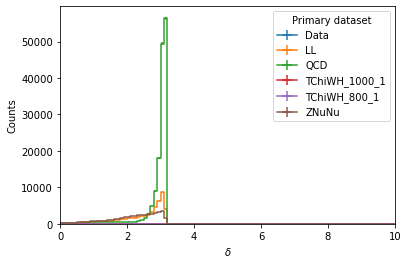

In [9]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

histogram = output['dphiDiFatJet']
ax = hist.plot1d(histogram,overlay="dataset", stack=False)

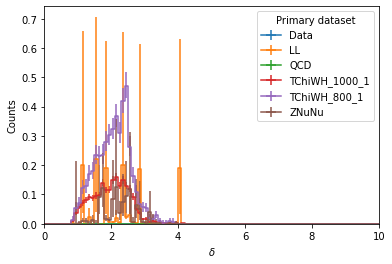

In [10]:
histogram = output['WH_deltaR']
ax = hist.plot1d(histogram,overlay="dataset", stack=False)

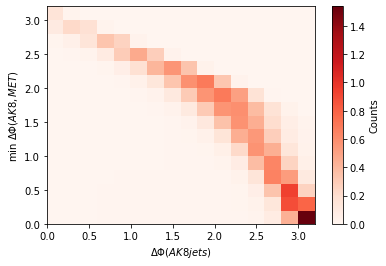

In [11]:

histogram = output['antiQCDcorrelation']['ZNuNu'].sum('dataset')

histogram = histogram.rebin('delta', hist.Bin('delta', r'$\Delta \Phi (AK8 jets)$', 16, 0, 3.2))
histogram = histogram.rebin('deltaPhi', hist.Bin('deltaPhi', r'min $\Delta \Phi (AK8, MET)$', 16, 0, 3.2))

#import mplhep
#plt.style.use(mplhep.style.CMS)
#figure=plt.figure(1)
ax = hist.plot2d(histogram, xaxis='delta', density=True, patch_opts={'cmap': plt.cm.Reds})


plt.show()

In [12]:
from plots.helpers import *
bins = {\
    'N_AK4':    {'axis': 'multiplicity',  'overflow':'over',  'bins': hist.Bin('multiplicity', r'$N_{AK4 jet}$', 6, -0.5, 5.5)},
    'N_AK4_SR':    {'axis': 'multiplicity',  'overflow':'over',  'bins': hist.Bin('multiplicity', r'$N_{AK4 jet}$', 6, -0.5, 5.5)},
    'N_AK8':    {'axis': 'multiplicity',  'overflow':'over',  'bins': hist.Bin('multiplicity', r'$N_{AK8 jet}$', 5, -0.5, 4.5)},
    'N_b':      {'axis': 'multiplicity',  'overflow':'over',  'bins': hist.Bin('multiplicity', r'$N_{b-tag}$', 5, -0.5, 4.5)},
    'N_H':      {'axis': 'multiplicity',  'overflow':'over',  'bins': hist.Bin('multiplicity', r'$N_{H-tag}$', 5, -0.5, 4.5)},
    'N_W':      {'axis': 'multiplicity',  'overflow':'over',  'bins': hist.Bin('multiplicity', r'$N_{W-tag}$', 5, -0.5, 4.5)},

    'MET_pt':   {'axis': 'pt',      'overflow':'over',  'bins': hist.Bin('pt', r'$p_{T}^{miss}\ (GeV)$', 20, 0, 800)},
    'MET_pt_SR':   {'axis': 'pt',      'overflow':'over',  'bins': hist.Bin('pt', r'$p_{T}^{miss}\ (GeV)$', np.array([250,400,600]))},
    'MET_pt_CR':   {'axis': 'pt',      'overflow':'over',  'bins': hist.Bin('pt', r'$p_{T}^{miss}\ (GeV)$', np.array([250,400,600]))},
    'HT':       {'axis': 'ht',      'overflow':'over',  'bins': hist.Bin('pt', r'$H_{T} (AK4 jets) \ (GeV)$', 25, 0, 2000)},    
    'W_pt':     {'axis': 'pt',      'overflow':'over',  'bins': hist.Bin('pt', r'$p_{T} (W-tag)$', 8, 200, 600)},
    'W_eta':    {'axis': 'eta',     'overflow':'over',  'bins': hist.Bin('eta', r'$\eta (W-tag)$', 15, -5.5, 5.5)},
    'H_pt':     {'axis': 'pt',      'overflow':'over',  'bins': hist.Bin('pt', r'$p_{T} (H-tag)$', 8, 200, 600)},
    'H_eta':    {'axis': 'eta',     'overflow':'over',  'bins': hist.Bin('eta', r'$\eta (H-tag)$', 15, -5.5, 5.5)},

    'dphiDiFatJet': {'axis': 'delta',          'overflow':'over',  'bins': hist.Bin('delta', r'$\Delta \phi (AK8)$', 30, 0, 3)},
    'dphiDiJet':    {'axis': 'delta',          'overflow':'over',  'bins': hist.Bin('delta', r'$\Delta \phi (AK4)$', 30, 0, 3)},
    'WH_deltaPhi':  {'axis': 'delta',          'overflow':'over',  'bins': hist.Bin('delta', r'$\Delta \phi (WH)$', 6, 0, 3)},
    'WH_deltaR':    {'axis': 'delta',          'overflow':'over',  'bins': hist.Bin('delta', r'$\Delta R (WH)$', 10, 0, 5)},
    'bb_deltaPhi':  {'axis': 'delta',          'overflow':'over',  'bins': hist.Bin('delta', r'$\Delta \phi (bb)$', 30, 0, 3)},
    'bb_deltaR':    {'axis': 'delta',          'overflow':'over',  'bins': hist.Bin('delta', r'$\Delta R (bb)$', 10, 0, 5)},
    'min_dphiJetMet4': {'axis': 'delta',          'overflow':'over',  'bins': hist.Bin('delta', r'$\Delta \phi (j, p_{T}^{miss})$', 30, 0, 3)},
        
    'mtb_min':      {'axis': 'mass',  'overflow':'over',  'bins': hist.Bin('pt', r'$min M_{T} (b, p_{T}^{miss}) \ (GeV)$', 25, 0, 500)},
    'lead_AK8_pt':  {'axis': 'pt',    'overflow':'over',  'bins': hist.Bin('pt', r'$p{T} (lead. AK8) \ (GeV)$', 20, 0, 1000)},
    }

In [23]:
from plots.helpers import *

def saveFig( fig, ax, rax, path, name, scale='linear', shape=False, y_max=-1 ):
    outdir = os.path.join(path,scale)
    finalizePlotDir(outdir)
    ax.set_yscale(scale)
    ax.set_ylabel('Events')

    if scale == 'linear':
        if y_max<0 or True:
            pass
        else:
            ax.set_ylim(0, 1 if shape else 1.2*y_max)
    else:
        if y_max<0 and not shape:
            pass
        else:
            ax.set_ylim(0.000005 if shape else 0.05, 3 if shape else 300*y_max)

    handles, labels = ax.get_legend_handles_labels()
    new_labels = []
    for handle, label in zip(handles, labels):
        #print (handle, label)
        try:
            new_labels.append(my_labels[label])
            if not label=='pseudodata':
                handle.set_color(colors[label])
        except:
            pass

    if rax:
        plt.subplots_adjust(hspace=0)
        rax.set_ylabel('Obs./Pred.')
        rax.set_ylim(0.5,1.5)

    ax.legend(title='',ncol=2,handles=handles, labels=new_labels, frameon=False)

    fig.text(0., 0.995, '$\\bf{CMS}$', fontsize=20,  horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes )
    fig.text(0.15, 1., '$\\it{Simulation}$', fontsize=14, horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes )
    fig.text(0.8, 1., '13 TeV', fontsize=14, horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes )

    fig.savefig(os.path.join(outdir, "{}.pdf".format(name)))
    fig.savefig(os.path.join(outdir, "{}.png".format(name)))
    #ax.clear()

/home/users/dspitzba/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)


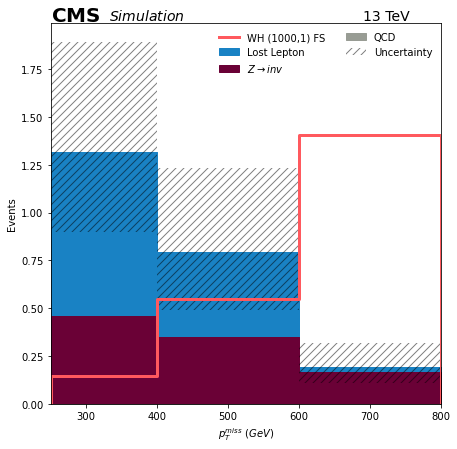

In [26]:
# Make some of the plots

plotDir = '/home/users/dspitzba/public_html/dump/WH_had/'
finalizePlotDir(plotDir)

if True:
    name = 'MET_pt_SR'

    histogram = output[name]

    axis = bins[name]['axis']
    histogram = histogram.rebin(axis, bins[name]['bins'])

    y_max = histogram.sum("dataset").values(overflow='all')[()].max()
    y_over = histogram.sum("dataset").values(overflow='all')[()][-1]

    import re
    bkgonly = re.compile('(?!(TChiWH|Data))')
    notdata = re.compile('(?!pseudodata)')
    notsignal = re.compile('(?!TChiWH)')

    fig, ax = plt.subplots(1,1,figsize=(7,7))
    
    # get axes
    hist.plot1d(histogram[bkgonly], overlay="dataset", ax=ax, stack=True, overflow=bins[name]['overflow'], clear=False, line_opts=None, fill_opts=fill_opts, error_opts=error_opts, order=['QCD', 'ZNuNu', 'LL']) #error_opts??
    hist.plot1d(histogram['TChiWH_1000_1'], overlay="dataset", ax=ax, overflow=bins[name]['overflow'], line_opts={'linewidth':3}, clear=False)
    #hist.plot1d(histogram['TChiWH_800_1'], overlay="dataset", ax=ax, overflow=bins[name]['overflow'], line_opts={'linewidth':3}, clear=False)

    for l in ['linear']:
        saveFig(fig, ax, None, plotDir, name, scale=l, shape=False, y_max=y_max)


<AxesSubplot:xlabel='$p_{T}^{miss}\\ (GeV)$', ylabel='Counts'>

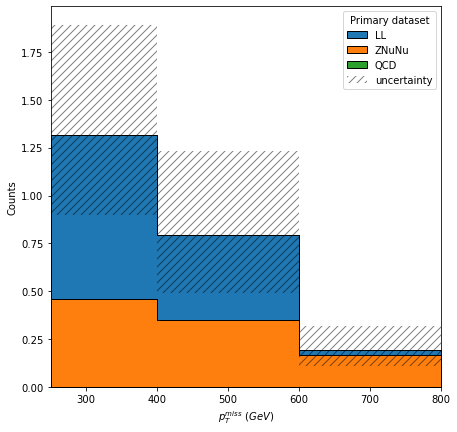

In [22]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
hist.plot1d(histogram[bkgonly], overlay="dataset", ax=ax, stack=True, overflow=bins[name]['overflow'], clear=False, line_opts=None, fill_opts=fill_opts, error_opts=error_opts, order=['QCD', 'ZNuNu', 'LL'])

In [27]:
histogram['LL'].values(overflow='over')

{('LL',): array([0.85726557, 0.43957028, 0.02597757])}

## Background prediction and validation region

In [30]:
# https://pythonhosted.org/uncertainties/user_guide.html
from uncertainties import ufloat
# https://pythonhosted.org/uncertainties/numpy_guide.html
from uncertainties import unumpy

## This can be either validation region or signal region

# First, add the years together using the add function of the histograms
# Then, use uncertainties.ufloat to do proper error propagation

def get_np_ufloat(vals):
    return unumpy.uarray( vals[0], np.sqrt(vals[1]) )
    #return np.array([ ufloat(vals[0][i], np.sqrt(vals[1][i])) for i in range(len(vals[0]))  ])

name = 'MET_pt_SR' # just for getting the right binning
axis = bins[name]['axis']
bkgonly = re.compile('(?!(Data|TChiWH))')
CR = 'MET_pt_CR' # the CR to use
SR = 'MET_pt_SR' # the SR to use - no worries, data is blinded in the *real* signal region

In [31]:
# load any cache to get some histogram
cache = dir_archive(os.path.join(os.path.expandvars(cfg['caches']['base']), "WH_2016"), serialized=True)
cache.load()

tmp = cache.get('simple_output')
hist_SR_all   = tmp[SR].copy()
hist_SR_all   = hist_SR_all.rebin(axis, bins[name]['bins'])
hist_SR_all.clear()

hist_CR_all   = tmp[SR].copy()
hist_CR_all   = hist_SR_all.rebin(axis, bins[name]['bins'])
hist_CR_all.clear()

years  = [2016,2017,2018]

for y in years:
    print ()
    print (y)
    # now, load the correct cache for each year
    cache = dir_archive(os.path.join(os.path.expandvars(cfg['caches']['base']), "WH_%s"%y), serialized=True)
    cache.load()
    tmp = cache.get('simple_output')
    
    # Get the histograms
    hist_SR = tmp[SR].copy()
    hist_CR = tmp[CR].copy()
    hist_SR = hist_SR.rebin(axis, bins[name]['bins'])
    hist_CR = hist_CR.rebin(axis, bins[name]['bins'])
    
    hist_SR_all.add(hist_SR.copy())
    hist_CR_all.add(hist_CR.copy())
    
    # Get the values
    Data_CR = get_np_ufloat( hist_CR['Data'].sum('dataset').values(overflow='over', sumw2=True)[()] )
    Data_SR = get_np_ufloat( hist_SR['Data'].sum('dataset').values(overflow='over', sumw2=True)[()] )
    LL_SR   = get_np_ufloat( hist_SR['LL'].sum('dataset').values(overflow='over', sumw2=True)[()] )
    ZInv_SR = get_np_ufloat( hist_SR['ZNuNu'].sum('dataset').values(overflow='over', sumw2=True)[()] )
    MC_CR   = get_np_ufloat( hist_CR[bkgonly].sum('dataset').values(overflow='over', sumw2=True)[()] )
    TF      = LL_SR / MC_CR
    LL_est  = Data_CR * TF
    
    res = {
        "N_CR":    Data_CR,
        "TF":      TF,
        "Z->inv":  ZInv_SR,
        "LL_est":  LL_est,
        "tot_est": LL_est + ZInv_SR,
        "obs":     Data_SR,
    }

    res_df = pd.DataFrame(res)
    
    print (res_df)
    

# Put everything together for full Run 2 prediction / validation

Data_CR = get_np_ufloat( hist_CR_all['Data'].sum('dataset').values(overflow='over', sumw2=True)[()] )
Data_SR = get_np_ufloat( hist_SR_all['Data'].sum('dataset').values(overflow='over', sumw2=True)[()] )
LL_SR   = get_np_ufloat( hist_SR_all['LL'].sum('dataset').values(overflow='over', sumw2=True)[()] )
ZInv_SR = get_np_ufloat( hist_SR_all['ZNuNu'].sum('dataset').values(overflow='over', sumw2=True)[()] )
MC_CR   = get_np_ufloat( hist_CR_all[bkgonly].sum('dataset').values(overflow='over', sumw2=True)[()] )
TF      = LL_SR / MC_CR
LL_est  = Data_CR * TF

run2 = {
    "N_CR":    Data_CR,
    "TF":      TF,
    "Z->inv":  ZInv_SR,
    "LL_est":  LL_est,
    "tot_est": LL_est + ZInv_SR,
    "obs":     Data_SR,
}

run2_df = pd.DataFrame(run2)

print ()
print ("Full Run2:")
print (run2_df)


2016
         N_CR             TF         Z->inv       LL_est        tot_est  \
0      34+/-6  0.010+/-0.006  0.073+/-0.031  0.34+/-0.21    0.41+/-0.21   
1  10.0+/-3.2        0.0+/-0    0.20+/-0.07      0.0+/-0    0.20+/-0.07   
2   3.0+/-1.7        0.0+/-0  0.007+/-0.014      0.0+/-0  0.007+/-0.014   

       obs  
0  0.0+/-0  
1  0.0+/-0  
2  0.0+/-0  

2017
        N_CR             TF         Z->inv       LL_est      tot_est      obs
0     49+/-7  0.011+/-0.004    0.29+/-0.09  0.52+/-0.23  0.81+/-0.25  0.0+/-0
1     14+/-4  0.015+/-0.010    0.14+/-0.05  0.20+/-0.15  0.35+/-0.16  0.0+/-0
2  3.0+/-1.7    0.06+/-0.06  0.030+/-0.011  0.18+/-0.21  0.21+/-0.21  0.0+/-0

2018
        N_CR               TF       Z->inv         LL_est      tot_est  \
0     86+/-9  0.0072+/-0.0033  0.46+/-0.17    0.62+/-0.29  1.08+/-0.34   
1     26+/-5    0.014+/-0.009  0.35+/-0.10    0.36+/-0.25  0.71+/-0.28   
2  4.0+/-2.0  0.0050+/-0.0034  0.16+/-0.08  0.020+/-0.017  0.18+/-0.09   

       obs  
0  0.0+